# 📂 Data Loading

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('youtube_ad_revenue_dataset (1).csv')


In [5]:
df.head()

,video_id,date,views,likes,comments,watch_time_minutes,video_length_minutes,subscribers,category,device,country,ad_revenue_usd
0,vid_3092,2024-09-24 10:50:40.993199,9936,1221.0,320.0,26497.214184,2.862137,228086,Entertainment,TV,IN,203.178237
1,vid_3459,2024-09-22 10:50:40.993199,10017,642.0,346.0,15209.747445,23.738069,736015,Gaming,Tablet,CA,140.880508
2,vid_4784,2024-11-21 10:50:40.993199,10097,1979.0,187.0,57332.658498,26.200634,240534,Education,TV,CA,360.134008
3,vid_4078,2025-01-28 10:50:40.993199,10034,1191.0,242.0,31334.517771,11.770340,434482,Entertainment,Mobile,UK,224.638261
4,vid_3522,2025-04-28 10:50:40.993199,9889,1858.0,477.0,15665.666434,6.635854,42030,Education,Mobile,CA,165.514388


In [6]:
df.shape

(122400, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   video_id              122400 non-null  object 
 1   date                  122400 non-null  object 
 2   views                 122400 non-null  int64  
 3   likes                 116283 non-null  float64
 4   comments              116288 non-null  float64
 5   watch_time_minutes    116295 non-null  float64
 6   video_length_minutes  122400 non-null  float64
 7   subscribers           122400 non-null  int64  
 8   category              122400 non-null  object 
 9   device                122400 non-null  object 
 10  country               122400 non-null  object 
 11  ad_revenue_usd        122400 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 11.2+ MB


# 📊 Exploratory Data Analysis (EDA)

Understand trends, distributions, correlations, and missing values.

In [8]:
df.isnull().mean().sort_values(ascending=False)

likes                   0.049975
comments                0.049935
watch_time_minutes      0.049877
video_id                0.000000
views                   0.000000
date                    0.000000
video_length_minutes    0.000000
subscribers             0.000000
category                0.000000
device                  0.000000
country                 0.000000
ad_revenue_usd          0.000000
dtype: float64

In [9]:
df.duplicated().sum()

np.int64(2400)

In [10]:
df = df.drop_duplicates()

In [11]:
df.duplicated().sum()

np.int64(0)

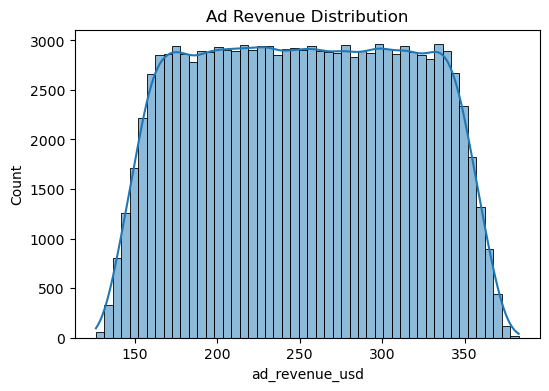

In [12]:
plt.figure(figsize=(6,4))
sns.histplot(df['ad_revenue_usd'], bins=50, kde=True)
plt.title('Ad Revenue Distribution')
plt.show()

In [13]:
df['ad_revenue_usd'].skew()


np.float64(0.0009478946949712697)

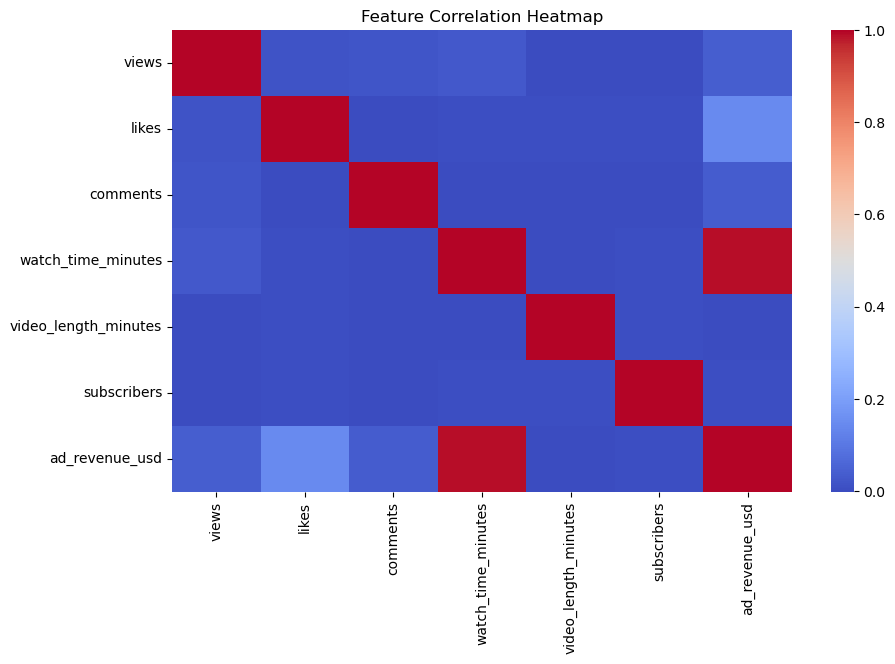

In [14]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

In [42]:
df.groupby('category')['ad_revenue_usd'].mean().sort_values(ascending=False).head(10)

category
Tech             253.458882
Gaming           253.426887
Education        252.564162
Music            252.477374
Entertainment    252.397546
Lifestyle        251.936934
Name: ad_revenue_usd, dtype: float64

# 🛠 Feature Engineering

Create new meaningful features to improve model performance.

In [43]:
df['engagement_rate'] = (df['likes'] + df['comments']) / df['views']

In [44]:
df['watch_time_per_min'] = df['watch_time_minutes'] / df['video_length_minutes']

In [45]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 🧹 Data Preprocessing

Handle missing values, outliers, and prepare data for modeling.

In [46]:
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns


for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)


for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [47]:
X = df.drop(['ad_revenue_usd', 'video_id', 'date'], axis=1)
y = df['ad_revenue_usd']

In [48]:
outlier_cols = [
    'views',
    'likes',
    'comments',
    'watch_time_minutes',
    'video_length_minutes',
    'subscribers'
]

for col in outlier_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)


# ✂ Train-Test Split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)

# ⚙ Pipeline Setup

In [50]:
numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns


numeric_transformer = Pipeline(steps=[
('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
('encoder', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
transformers=[
('num', numeric_transformer, numeric_features),
('cat', categorical_transformer, categorical_features)
]
)

# 🤖 Model Training & Evaluation

In [51]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    mae = mean_absolute_error(y_test, y_pred)
    
    return r2, rmse, mae


In [52]:
models = {
'Linear Regression': LinearRegression(),
'Ridge': Ridge(alpha=1.0),
'Lasso': Lasso(alpha=0.01),
'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5),
'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}


results = []


for name, model in models.items():
    r2, rmse, mae = evaluate_model(model, X_train, X_test, y_train, y_test)
    results.append([name, r2, rmse, mae])


results_df = pd.DataFrame(results, columns=['Model', 'R2', 'RMSE', 'MAE'])
results_df.sort_values(by='R2', ascending=False)

,Model,R2,RMSE,MAE
2,Lasso,0.952586,13.478276,3.082634
0,Linear Regression,0.952578,13.479448,3.107252
1,Ridge,0.952578,13.479449,3.107297
3,ElasticNet,0.952545,13.484216,3.260726
4,Random Forest,0.949699,13.882629,3.545342


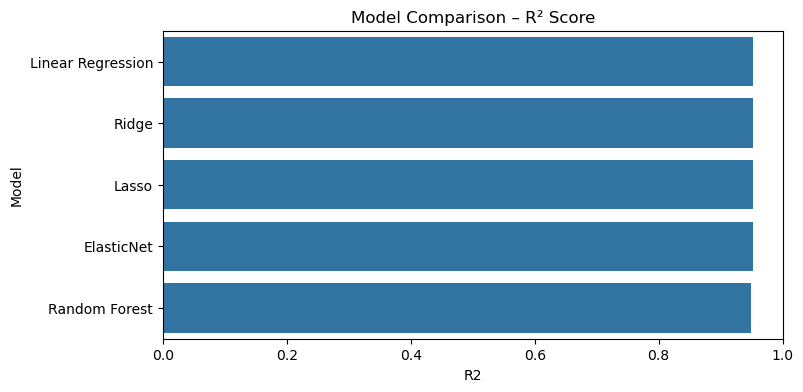

In [53]:
plt.figure(figsize=(8,4))
sns.barplot(x='R2', y='Model', data=results_df)
plt.title('Model Comparison – R² Score')
plt.show()

In [54]:
lasso_model = Lasso(alpha=0.01)

lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lasso_model)
])

lasso_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['views', 'likes', 'comments', 'watch_time_minutes',
       'video_length_minutes', 'subscribers', 'engagement_rate',
       'watch_time_per_min'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['category', 'device', 'country'], dtype='object'))])),
                ('model', Lasso(alpha=0.01))])

In [55]:
# Numeric feature names
num_features = numeric_features

# Categorical feature names after OneHotEncoding
cat_features = (
    lasso_pipeline
    .named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['encoder']
    .get_feature_names_out(categorical_features)
)

# Combine all feature names
all_features = np.concatenate([num_features, cat_features])


In [56]:
coefficients = lasso_pipeline.named_steps['model'].coef_


In [57]:
lasso_coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients
})


In [58]:
lasso_coef_df = lasso_coef_df[lasso_coef_df['Coefficient'] != 0]


In [59]:
lasso_coef_df['Abs_Coefficient'] = lasso_coef_df['Coefficient'].abs()

lasso_coef_df = lasso_coef_df.sort_values(
    by='Abs_Coefficient', ascending=False
)


In [60]:
lasso_coef_df.head(10)


,Feature,Coefficient,Abs_Coefficient
3,watch_time_minutes,59.663172,59.663172
1,likes,8.487750,8.487750
2,comments,2.078326,2.078326
0,views,0.653885,0.653885
6,engagement_rate,0.169953,0.169953
16,device_TV,-0.118965,0.118965
4,video_length_minutes,0.038498,0.038498
14,device_Desktop,0.035998,0.035998
7,watch_time_per_min,0.035321,0.035321
21,country_IN,0.029562,0.029562


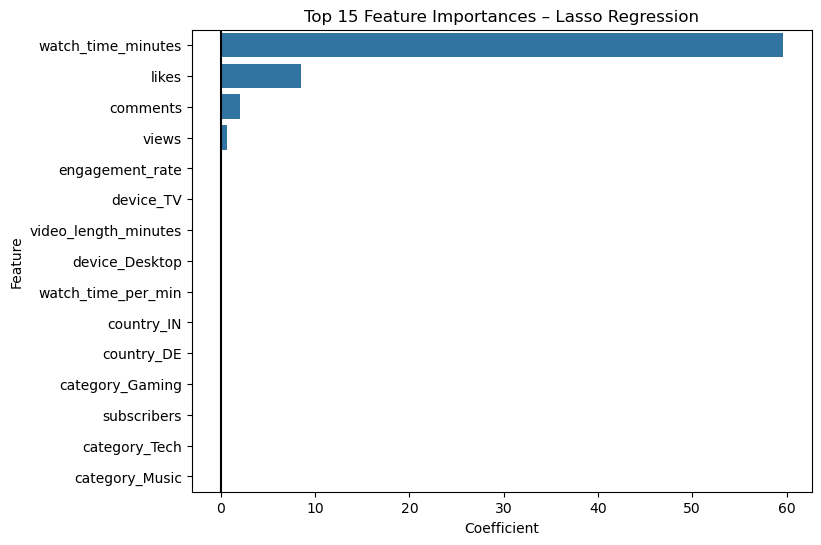

In [61]:
plt.figure(figsize=(8,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=lasso_coef_df.head(15)
)
plt.title('Top 15 Feature Importances – Lasso Regression')
plt.axvline(0, color='black')
plt.show()


In [62]:
lasso_pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['views', 'likes', 'comments', 'watch_time_minutes',
       'video_length_minutes', 'subscribers', 'engagement_rate',
       'watch_time_per_min'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['category', 'device', 'country'], dtype='object'))])),
                ('model', Lasso(alpha=0.01))])

# 💾 Model Saving (Deployment Ready)

In [64]:
import joblib

joblib.dump(lasso_pipeline, 'lasso_ad_revenue_model.joblib')


['lasso_ad_revenue_model.joblib']

In [65]:
loaded_model = joblib.load('lasso_ad_revenue_model.joblib')
